<a href="https://colab.research.google.com/github/quinbez/Machine-Translation/blob/main/Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Environment Setup**

In [1]:
!pip install -U portalocker -q
!python -m spacy download en_core_web_sm -q
!python -m spacy download fr_core_news_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 48.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### **Import**

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt

Now, to ensure reproducibility, we set a random seed for various libraries:

In [3]:
# Set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

### **Download Dataset**

In [4]:
!pip install kaggle

In [5]:
import os
os.environ['KAGGLE_USERNAME'] = 'quinbez'
os.environ['KAGGLE_KEY'] = '4028034f69db46ce734bd2bf57a32868'

dataset = 'devicharith/language-translation-englishfrench'

!kaggle datasets download -d $dataset

  0% 0.00/3.51M [00:00<?, ?B/s]
100% 3.51M/3.51M [00:00<00:00, 206MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('language-translation-englishfrench.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

### **Dataset Preparation**

Let’s dissect the dataset preparation steps for our English to French translation task using PyTorch nn.Transformer

In [7]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'fr'

Use the get_tokenizer() function from the torchtext.data.utils module to obtain tokenizer functions for the source and target languages

In [8]:
token_transform = {}
vocab_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='fr_core_news_sm')

Reading our dataset from a CSV file, which contains columns for both English and French sentences

In [9]:
csv = pd.read_csv(
    '/content/dataset/eng_-french.csv',
    usecols=['English words/sentences', 'French words/sentences']
)
csv.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


Split our dataset into training and testing subsets using train_test_split from scikit-learn. Here, 90% of the data is used for training, and the remaining 10% is reserved for testing.

In [10]:
train_csv, test_csv = train_test_split(csv, test_size=0.1)

**Custom Dataset Class**

In [11]:
class TranslationDataset(Dataset):
   def __init__(self, csv):
       self.csv = csv

   def __len__(self):
       return len(self.csv)

   def __getitem__(self, idx):
       return(
           self.csv['English words/sentences'].iloc[idx],
           self.csv['French words/sentences'].iloc[idx]
           )

Let’s initialize the dataset and print one pair of sample:

In [12]:
train_dataset = TranslationDataset(train_csv)
valid_dataset = TranslationDataset(test_csv)
iterator = iter(train_dataset)
print(next(iterator))

('They kept him waiting outside for a long time.', 'Ils le firent poireauter dehors.')


In [13]:
print(next(iterator))

('How much money did you spend on your car?', "Combien d'argent avez-vous dépensé pour votre voiture ?")


**Helper Functions for Dataset Preparation**

In [14]:
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices.
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

# Make sure the tokens are in order of their indices to properly insert them in vocab.
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Create torchtext's Vocab object.
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_dataset, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

```
UNK_IDX: Represents unknown words.
PAD_IDX: Used for padding shorter sequences.
BOS_IDX: Denotes the beginning of a sequence.
EOS_IDX: Denotes the end of a sequence.

```

In [15]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# `src` and `tgt` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

### **Model and Training Hyperparameters**

In [16]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 192
NHEAD = 6
FFN_HID_DIM = 192
BATCH_SIZE = 192
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = 'cuda'
NUM_EPOCHS = 25

Generate masks for the source and target sentences:

In [17]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def create_mask(src, tgt):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)
    src_padding_mask = (src == PAD_IDX)
    tgt_padding_mask = (tgt == PAD_IDX)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Define a class for Positional encoding:

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

Define a layer to transform tokens into embeddings:

In [19]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

Define the entire Transformer model:

In [20]:
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers: int,
        num_decoder_layers: int,
        emb_size: int,
        nhead: int,
        src_vocab_size: int,
        tgt_vocab_size: int,
        dim_feedforward: int = 512,
        dropout: float = 0.1
    ):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)
    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

Initialize the model and print the total number of parameters:

In [21]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS,
    NUM_DECODER_LAYERS,
    EMB_SIZE,
    NHEAD,
    SRC_VOCAB_SIZE,
    TGT_VOCAB_SIZE,
    FFN_HID_DIM
).to(DEVICE)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
print(model)

14,487,719 total parameters.
14,487,719 training parameters.
Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
          (linear1): Linear(in_features=192, out_features=192, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=192, out_features=192, bias=True)
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x Tr

Define the loss function and the optimizer:

In [22]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

### **Data Loaders and Training & Validation Loops**

Define the data loaders and the entirety of training and validation functions:

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def train_epoch(model, optimizer):
    print('Training')
    model.train()
    losses = 0
    for src, tgt in tqdm(train_dataloader, total=len(list(train_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )
        optimizer.zero_grad()
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        losses += loss.item()
    return losses / len(list(train_dataloader))
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
def evaluate(model):
    print('Validating')
    model.eval()
    losses = 0
    for src, tgt in tqdm(val_dataloader, total=len(list(val_dataloader))):
        # print(" ".join(vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        # print(" ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt[0].cpu().numpy()))).replace("<bos>", "").replace("<eos>", ""))
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:, :-1]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask
        )
        tgt_out = tgt[:, 1:]
        loss = loss_fn(logits.view(-1, TGT_VOCAB_SIZE), tgt_out.contiguous().view(-1))
        losses += loss.item()
    return losses / len(list(val_dataloader))

 We loop through the desired number of epochs, training and validating the model at each epoch:

In [26]:
train_loss_list, valid_loss_list = [], []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    valid_loss = evaluate(model)
    end_time = timer()
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {valid_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s \n"))

Training


  0%|          | 0/824 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 1, Train loss: 5.369, Val loss: 4.185, Epoch time = 169.906s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 2, Train loss: 3.946, Val loss: 3.538, Epoch time = 168.573s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 3, Train loss: 3.480, Val loss: 3.179, Epoch time = 168.194s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 4, Train loss: 3.178, Val loss: 2.925, Epoch time = 168.642s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 5, Train loss: 2.953, Val loss: 2.729, Epoch time = 168.197s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 6, Train loss: 2.773, Val loss: 2.567, Epoch time = 169.409s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 7, Train loss: 2.621, Val loss: 2.431, Epoch time = 170.867s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 8, Train loss: 2.491, Val loss: 2.315, Epoch time = 171.684s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 9, Train loss: 2.379, Val loss: 2.216, Epoch time = 170.969s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 10, Train loss: 2.282, Val loss: 2.130, Epoch time = 169.460s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 11, Train loss: 2.194, Val loss: 2.056, Epoch time = 169.693s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 12, Train loss: 2.118, Val loss: 1.990, Epoch time = 169.592s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 13, Train loss: 2.049, Val loss: 1.934, Epoch time = 169.260s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 14, Train loss: 1.986, Val loss: 1.882, Epoch time = 169.407s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 15, Train loss: 1.928, Val loss: 1.839, Epoch time = 170.126s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 16, Train loss: 1.878, Val loss: 1.796, Epoch time = 169.935s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 17, Train loss: 1.830, Val loss: 1.760, Epoch time = 169.675s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 18, Train loss: 1.786, Val loss: 1.730, Epoch time = 169.613s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 19, Train loss: 1.745, Val loss: 1.697, Epoch time = 170.977s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 20, Train loss: 1.709, Val loss: 1.672, Epoch time = 170.602s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 21, Train loss: 1.674, Val loss: 1.646, Epoch time = 169.932s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 22, Train loss: 1.643, Val loss: 1.623, Epoch time = 169.654s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 23, Train loss: 1.613, Val loss: 1.603, Epoch time = 170.054s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 24, Train loss: 1.586, Val loss: 1.585, Epoch time = 171.247s 

Training


  0%|          | 0/824 [00:00<?, ?it/s]

Validating


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 25, Train loss: 1.559, Val loss: 1.567, Epoch time = 170.755s 



### **Saving Model and Loss Plots**

Let’s create a new 'outputs' directory and save the model and the loss plots.

In [27]:
os.makedirs('outputs', exist_ok=True)

In [28]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss plots to disk.
    """
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join('outputs', 'loss.png'))
    plt.show()

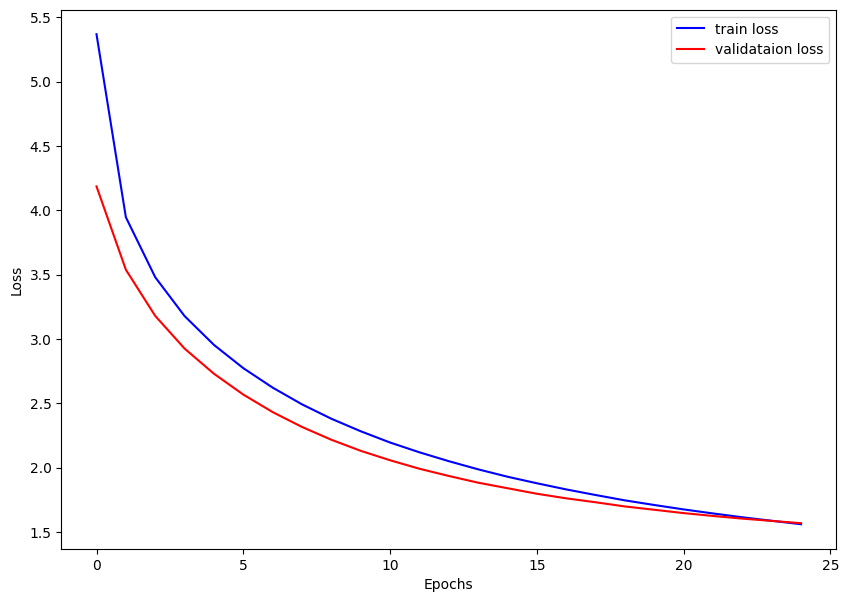

In [29]:
save_plots(train_loss_list, valid_loss_list)

Save the model to disk:

In [30]:
# torch.save(model, 'outputs/model.pth')

### **Inference using the Trained Language Translation Model**

Inference involves taking a sentence in the source language and producing its equivalent in the target language.

We begin by loading our previously saved model:

In [ ]:
# model = torch.load('outputs/model.pth')

We define two helper functions to carry out inference:

In [31]:
# Helper function to generate output sequence using greedy algorithm.
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if i == 0:
            ys = ys.transpose(1, 0)
        tgt_mask = (generate_square_subsequent_mask(ys.size(1))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        if next_word == EOS_IDX:
            break
    return ys
# Translation function.
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

To produce translations, we employ a method called “**greedy decoding**”. It’s a straightforward approach where, for each step, we pick the word with the highest probability as our next word in the sequence.

In this function:

We start the translation with a predefined start symbol.
For each subsequent word, we append the model’s prediction to the current sequence.
This process continues until either we reach a predefined maximum length for the translation or the model generates an end-of-sequence (EOS) token.
Here’s what happens in the translate function:

We set the model to evaluation mode. This disables operations like dropout.
Then we convert the source sentence into its corresponding token representation.
The greedy_decode function is used to generate the translated sentence in token format.
Finally, the tokenized sentence is transformed back into a human-readable format, and special tokens (<bos> and <eos>) are removed.
In the next block, we choose a few English sentences from the validation split to carry out inference on. We create a list of lists to store the English and French sentences. This will make it easier for us to compare the ground truth and predicted French sentences.

In [32]:
# SRC, GT pairs from the validation set.
infer_sentences = [
    ["Take a seat.", "Prends place !"],
    ["I'm not scared to die", "Je ne crains pas de mourir."],
    ["You'd better make sure that it is true.", "Tu ferais bien de t'assurer que c'est vrai."],
    ["The clock has stopped.", "L'horloge s'est arrêtée."],
    ["Take any two cards you like.", "Prends deux cartes de ton choix."]
]
for sentence in infer_sentences:
    print(f"SRC: {sentence[0]}")
    print(f"GT: {sentence[1]}")
    print(f"PRED: {translate(model, sentence[0])}\n")

SRC: Take a seat.
GT: Prends place !
PRED:  Prends une chaise ! 

SRC: I'm not scared to die
GT: Je ne crains pas de mourir.
PRED:  Je ne suis pas effrayé à mourir . 

SRC: You'd better make sure that it is true.
GT: Tu ferais bien de t'assurer que c'est vrai.
PRED:  Tu ferais mieux de faire cela que c' est vrai . 

SRC: The clock has stopped.
GT: L'horloge s'est arrêtée.
PRED:  La horloge s' est arrêté . 

SRC: Take any two cards you like.
GT: Prends deux cartes de ton choix.
PRED:  Prends les cartes de vos cartes comme vous . 

